In [22]:
%matplotlib inline

from typing import List, Tuple
import numpy as np
from scipy.signal import convolve2d, fftconvolve
from skimage.filters import gaussian
from skimage.exposure import rescale_intensity
from skimage import data, color
from skimage.transform import rescale
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [10, 10]

show_images = True
crop_y = 500 # 340
crop_x = 0 # 125
crop_dim = 10 # 90
laplace_term = 1.0

In [23]:
def show_image(img):
    if(show_images):
        plt.imshow(img, cmap=plt.cm.gray)
        plt.colorbar()
        plt.show()
        
def show_images(images: List[Tuple]) -> None:
    n: int = len(images)
    f = plt.figure()
    f.set_size_inches(18.5, 10.5)
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i][0], cmap="hot")
        plt.title(images[i][1])
        plt.colorbar(orientation="horizontal")

    plt.show()

## Perform experiment using spatial-domain convolution of 3x3 Laplacian

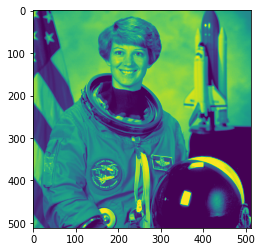

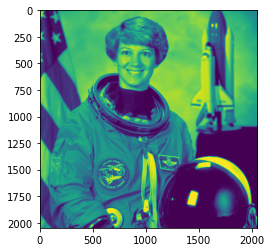

In [25]:
# spatial_results = []

image = color.rgb2gray(data.astronaut())
plt.imshow(image)
plt.show()

image = rescale(image, 4, anti_aliasing=True)
plt.imshow(image)
plt.show()


# spatial_results.append((image[crop_y:crop_y+crop_dim, crop_x:crop_x+crop_dim], "Original"))

blurred = gaussian(image)
# spatial_results.append((blurred[crop_y:crop_y+crop_dim, crop_x:crop_x+crop_dim], "Original with Gaussian Blur"))

laplace = np.array([[0, -laplace_term,  0], [-laplace_term,  1 + 4 * laplace_term, -laplace_term], [0, -laplace_term,  0]], dtype=np.float32)

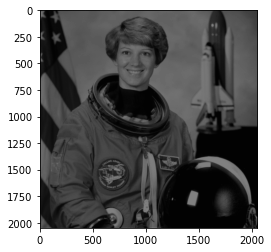

In [34]:

deblurred = convolve2d(blurred, laplace, mode="same")
plt.imshow(deblurred, cmap=plt.cm.gray)
plt.show()

In [27]:
# spatial_results.append((deblurred[crop_y:crop_y+crop_dim, crop_x:crop_x+crop_dim], "Spatial Deblur"))
# show_images(spatial_results)

## Perform experiment using Fourier-domain multiplication using FFT + multiply (via Scipy library)

In [28]:
# scipy_fft_results = []

# scipy_fft_results.append((image[crop_y:crop_y+crop_dim, crop_x:crop_x+crop_dim], "Original"))
# scipy_fft_results.append((blurred[crop_y:crop_y+crop_dim, crop_x:crop_x+crop_dim], "Original with Gaussian Blur"))

laplace_padded = np.pad(laplace, (image.shape[0]//2 - 1, image.shape[0]//2 - 1))

In [29]:
%%timeit
scipy_fft_deblurred = fftconvolve(blurred, laplace_padded, mode="same")

336 ms ± 1.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
# scipy_fft_results.append((scipy_fft_deblurred[crop_y:crop_y+crop_dim, crop_x:crop_x+crop_dim], "Scipy FFTConvolve"))

# deblurred = rescale_intensity(deblurred, out_range=(0.0, 1.0))
# fft_deblurred = rescale_intensity(fft_deblurred, out_range=(0.0, 1.0))
 
# abs_diff = np.absolute(deblurred - fft_deblurred)
# print(np.sum(abs_diff))
# show_image(deblurred[crop_y:crop_y+crop_dim, crop_x:crop_x+crop_dim] - fft_deblurred[crop_y:crop_y+crop_dim, crop_x:crop_x+crop_dim])

# show_images(scipy_fft_results)

## Perform experiment using Fourier-domain multiplication using FFT + multiply (via Numpy library)

In [31]:
# numpy_fft_results = []

# numpy_fft_results.append((image[crop_y:crop_y+crop_dim, crop_x:crop_x+crop_dim], "Original"))
# numpy_fft_results.append((blurred[crop_y:crop_y+crop_dim, crop_x:crop_x+crop_dim], "Original with Gaussian Blur"))

img_shape = image.shape[0]
laplace_padded = np.pad(laplace, (img_shape//2 - 1, img_shape//2 - 2))
# print(np.unravel_index(np.argmax(laplace_padded, axis=None), laplace_padded.shape))
# numpy_fft_results.append(laplace_padded)

laplace_padded_fft = np.fft.fft2(np.fft.fftshift(laplace_padded))
# numpy_fft_results.append(laplace_padded_fft.real)

In [32]:
%%timeit
blurred_fft = np.fft.fftshift(np.fft.fft2((blurred)))
blurred_fft /= np.max(blurred_fft.real)
# numpy_fft_results.append(blurred_fft.real)

fft_mul_result = blurred_fft * laplace_padded_fft
# print(fft_mul_result.shape)

# plt.plot(laplace_padded_fft.real[256])
# plt.plot(blurred_fft.real[256])
# plt.plot(fft_mul_result.real[256])
# plt.show()

numpy_fft_deblurred = np.fft.ifft2(np.fft.ifftshift(fft_mul_result)).real
# numpy_fft_results.append((numpy_fft_deblurred[crop_y:crop_y+crop_dim, crop_x:crop_x+crop_dim], "Numpy FFT + Multiply"))

# show_images(numpy_fft_results)

170 ms ± 1.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Compare the outputs of each implementation

In [ ]:
results = []

# results.append((image[crop_y:crop_y+crop_dim, crop_x:crop_x+crop_dim], "Original"))
# results.append((blurred[crop_y:crop_y+crop_dim, crop_x:crop_x+crop_dim], "Original with Gaussian Blur"))
# results.append((deblurred[crop_y:crop_y+crop_dim, crop_x:crop_x+crop_dim], "Spatial Deblur"))
# results.append((scipy_fft_deblurred[crop_y:crop_y+crop_dim, crop_x:crop_x+crop_dim], "Scipy FFTConvolve"))

image = image[:, :]
# image = rescale_intensity(image, out_range=(0.0, 1.0))

blurred = blurred[:, :]
# blurred = rescale_intensity(blurred, out_range=(0.0, 1.0))

deblurred = deblurred[:, :]
# deblurred = np.clip(deblurred, 0.0, 1.0)
# deblurred = rescale_intensity(deblurred, out_range=(0.0, 1.0))

scipy_fft_deblurred = scipy_fft_deblurred[:, :]
# scipy_fft_deblurred = rescale_intensity(scipy_fft_deblurred, out_range=(0.0, 1.0))

results.append((image, "Original"))
print(np.unravel_index(np.argmax(image, axis=None), laplace_padded.shape))
results.append((blurred, "Original with Gaussian Blur"))
print(np.unravel_index(np.argmax(blurred, axis=None), laplace_padded.shape))
results.append((deblurred, "Spatial Deblur"))
print(np.unravel_index(np.argmax(deblurred, axis=None), laplace_padded.shape))
results.append((scipy_fft_deblurred, "Scipy FFTConvolve"))
print(np.unravel_index(np.argmax(scipy_fft_deblurred, axis=None), laplace_padded.shape))

plt.plot(image)
plt.show()
plt.plot(deblurred)

show_images(results)

print(np.sum(deblurred))
print(np.sum(scipy_fft_deblurred))
print(np.sum(image))
print(np.sum(scipy_fft_deblurred) / np.sum(image) * 100)

In [ ]:
# norm_results = []
# # (data - np.min(data)) / (np.max(data) - np.min(data))
# norm_results.append(((image - np.min(image)) / (np.max(image) - np.min(image)), "Original"))
# norm_results.append(((blurred - np.min(blurred)) / (np.max(blurred) - np.min(blurred)), "Original with Gaussian Blur"))
# norm_results.append(((deblurred - np.min(deblurred)) / (np.max(deblurred) - np.min(deblurred)), "Spatial Deblur"))
# norm_results.append(((scipy_fft_deblurred - np.min(scipy_fft_deblurred)) / (np.max(scipy_fft_deblurred) - np.min(scipy_fft_deblurred)), "Scipy FFTConvolve"))

# show_images(norm_results)